<a href="https://colab.research.google.com/github/kla55/Pytorch_learning/blob/main/projects/simple_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
import torchvision.transforms as transforms

from torchvision.transforms import ToTensor, Resize, Compose


transformations = Compose([
    Resize((28, 28)),  # Resize each image to 256x256
    ToTensor()           # Then convert them to Tensor
])

In [9]:
train_data = datasets.Food101(
    root="data",
    split='train',
    download=True,
    transform=transformations
)

test_data = datasets.Food101(
    root="data",
    split='test',
    download=True,
    transform=transformations
)

In [10]:
num_classes = len(train_data.classes)
num_classes

101

47186
12706
10318
25431
5892


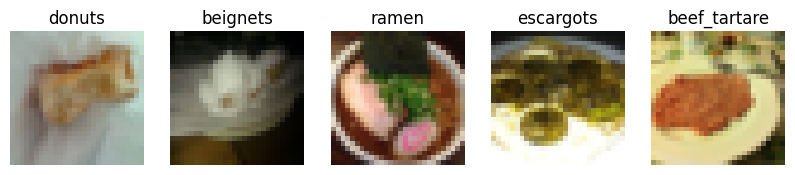

In [11]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,15))
rows, cols = 1, 5
for i in range(1, 6):
  random_inx = torch.randint(0,len(train_data), size =[1]).item()
  print(random_inx)
  image, label = train_data[random_inx]
  image = np.transpose(image, (1, 2, 0))
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap = 'gray')
  plt.title(train_data.classes[label])
  plt.axis(False)


In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x789ef249a020>, <torch.utils.data.dataloader.DataLoader object at 0x789ef249a080>)
Length of train dataloader: 2368 batches of 32
Length of test dataloader: 790 batches of 32


In [9]:
train_features, train_labels = next(iter(train_data))

In [10]:
train_features.shape

torch.Size([3, 28, 28])

In [ ]:
from torch import nn

class model_v0(torch.nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
                    nn.Conv2d(in_channels=input_shape,
                              out_channels=hidden_units,
                              kernel_size=3,
                              stride=1,
                              padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2))

    self.conv_block_2 = nn.Sequential(
                      nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                      nn.ReLU(),
                      nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2))

    self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=hidden_units*7*7,
                              out_features=output_shape))

  def forward(self, x):
                    x = self.conv_block_1(x)
                    # print(f"Output shape of conv block 1: {x.shape}")
                    x = self.conv_block_2(x)
                    # print(f"Output shape of conv block 2: {x.shape}")
                    x = self.classifier(x)
                    # print(f"Output shape of classifier: {x.shape}")
                    return x

In [ ]:
model_V0 = model_v0(input_shape=3,
                  hidden_units=10,
                  output_shape=101).to(device)
model_V0



In [ ]:
dummy_x = torch.rand(size = (3, 28, 28)).unsqueeze( dim = 0).to(device)
model_V0(dummy_x)


In [ ]:
from tqdm.auto import tqdm

model_cpu = model_v0(input_shape=3,
                    hidden_units=10,
                    output_shape=101)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cpu.parameters(), lr=0.1)

In [ ]:
EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
  train_loss = 0
  model_cpu.train()
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to('cpu'), y.to('cpu')
    y_pred = model_cpu(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)

  test_loss_total = 0
  model_cpu.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to("cpu"), y_test.to("cpu")
      test_pred = model_cpu(X_test)
      test_loss = loss_fn(test_pred, y_test)
      test_loss_total += test_loss
    test_loss_total /= len(test_dataloader)

  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")

In [11]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

In [12]:
# with resnet
import torchvision.models as models
import torch.nn as nn

model = models.resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:04<00:00, 43.7MB/s]


In [13]:
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, 101, device)

In [14]:
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

In [16]:
device

'cuda'

In [17]:
train_dataset = datasets.Food101(
    root="data",
    split='train',
    download=True,
    transform=transformations
)

evaluation_dataset = datasets.Food101(
    root="data",
    split='test',
    download=True,
    transform=transformations
)

In [20]:
batch_size = 32
image_size = 224

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=2)

evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = 32, shuffle=False, num_workers=2)

In [22]:
%%time

num_epochs = 15
losses = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        #train model
        outputs = model(inputs)

        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        #backward
        optimizer.zero_grad()
        loss.backward()

        #update parameters
        optimizer.step()

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item()))


KeyboardInterrupt: ignored

In [ ]:
projects/simple_nn.ipynb